In [1]:
import random
from math import cos, sin

import checker
import matplotlib.pyplot as plt
import numpy as np
import utils

## Po co nam to numpy?
Przydaje nam się z kilku powodów:
* Napisanie jednej linijki w numpy jest szybsze i wygodniejsze niż napisanie pętli, jest też mniejsza szansa, że zrobimy gdzieś po drodze błąd. Oczywiście najpierw trzeba się przyzwyczaić do intefejsu.
* Numpy jest znacznie bardziej wydajny niż napisane przez nas funkcje w "czystym" Pythonie.
* PyTorch, biblioteka do głębokiego uczenia, z której później będziemy korzystać, ma bardzo podobny interfejs.

### Kilka przykładów

In [2]:
%%timeit

X = [random.random() for _ in range(10000)]
y = [sin(x) + cos(x) for x in X]

1.91 ms ± 4.46 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
%%timeit

X = np.random.random(10000)
y = np.sin(X) + np.cos(X)

129 µs ± 382 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [4]:
def almost_variance(x: np.ndarray) -> np.ndarray:
    """Oblicza 1/n * SUM (x_i - mean(x))^4"""
    m = sum(x) / len(x)
    result = 0
    for i in range(len(x)):
        result += (x[i] - m) ** 4
    result /= len(x)
    return result


def numpy_almost_var(x: np.ndarray) -> np.ndarray:
    m = np.mean(x)
    powers = (x - m) ** 4
    return np.mean(powers)


X = np.random.random(10000)

In [5]:
%%timeit
almost_variance(X)

2.78 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%%timeit
numpy_almost_var(X)

198 µs ± 674 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Zadanie 1. (3 pkt.)
Wykonać poniższe ćwiczenia przy pomocy Numpy:

1. Wykorzystując `broadcasting` (patrz na rysunek poniżej) stwórz funkcję, która dla zadnego $K$ zwraca tabliczkę mnożenia, tzn. tablicę $A$ taką, że: $$A_{ij} = i \cdot j\;\;\;\;\; \forall i,j \in \{1,\dots,K\}$$
    <img src="http://www.astroml.org/_images/fig_broadcast_visual_1.png">

    Przydatne funkcje: `np.arange`, `np.reshape`. 

In [7]:
def multiplication_table(k: int) -> np.ndarray:
    A = np.arange(1, k+1).reshape(k, 1)
    B = np.arange(1, k+1)
    return A*B


print("Wynik funkcji multiplication:\n", multiplication_table(10))
checker.check_multiplication_table(multiplication_table)

Wynik funkcji multiplication:
 [[  1   2   3   4   5   6   7   8   9  10]
 [  2   4   6   8  10  12  14  16  18  20]
 [  3   6   9  12  15  18  21  24  27  30]
 [  4   8  12  16  20  24  28  32  36  40]
 [  5  10  15  20  25  30  35  40  45  50]
 [  6  12  18  24  30  36  42  48  54  60]
 [  7  14  21  28  35  42  49  56  63  70]
 [  8  16  24  32  40  48  56  64  72  80]
 [  9  18  27  36  45  54  63  72  81  90]
 [ 10  20  30  40  50  60  70  80  90 100]]


2. Mając daną tablice jednowymiarową oraz liczbę `x` znajdź najbliższą wartość `x` w `A`, tzn. 
    $$ \mathrm{closest}(x, A) = \arg\min_{a\in A}|x - a|  $$

    Przydatne funkcje: `np.argmin`, `np.abs`. 

In [8]:
def closest(x: float, A: np.ndarray) -> np.ndarray:
    B = np.abs(x-A)
    return A[np.argmin(B)]


print("Wynik funkcji closest:", closest(9, np.array([5, 8, 14])))
checker.check_closest(closest)

Wynik funkcji closest: 8


3. Zaimplementuj proste liczenie wartosci wielomianu o zadanych współczynnikach (analogię `np.poly1d`), czyli funkcję

    $$
    \mathrm{poly}(x, a) = a_0 + a_1 x + a_2 x^2 + \dots + a_k x^k = \sum_{i=1}^k a_i x^i
    $$

    Potencjalnie przydatne funkcje: `np.cumprod`, `np.concatenate`, `np.sum`.

In [9]:
def poly(x: int, a: np.ndarray) -> np.ndarray:
    if(a.size < 1):
        return 0
    for i in range(a.size-1):
        a[i] = x**(a.size - i - 1)*a[i]
    return np.sum(a)


print("Wynik funkcji poly:", poly(3, np.array([1, 2, 4])))
checker.check_poly(poly)

Wynik funkcji poly: 19


AssertionError: Jest błąd w funkcji poly!

## Zadanie 2. (2 pkt.)
Dla macierzy $X$ o wymiarze `[N, D]` zaimplementować operację whiteningu: 

$\mathrm{whiten}(X) = (X-\mathrm{mean} X)(\mathrm{cov} X)^{-1/2}$

$\mathrm{mean} X$ rozumiemy jako wektor wierszowy, którego każdy element jest zdefiniowany jako: $$(\mathrm{mean}X)_i = \frac{1}{N} \sum_{j=1}^N X_{ij}$$

**Uwaga 1: np.cov przyjmuje, że każdy wiersz macierzy to osobna cecha, a każda kolumna to osobna obserwacja - czyli odwrotnie niż u nas. Dlatego przed podaniem naszej macierzy do np.cov trzeba ją transponować.**

**Uwaga 2: pierwiastek z macierzy to nie to samo co pierwiastkowanie element-wise, takie jak w np.sqrt. Najlepiej poszukać odpowiedniej funkcji w bibliotece scipy i ją zaimportować.**

In [12]:
from scipy.linalg import fractional_matrix_power


def whiten(X: np.ndarray) -> np.ndarray:
    m_X = np.mean(X, axis=0)
    X = X - m_X
    cov_X = np.cov(X, rowvar=False)
    cov_X = fractional_matrix_power(cov_X, -0.5)
    X_white = np.dot(X, cov_X)
    
    return X_white

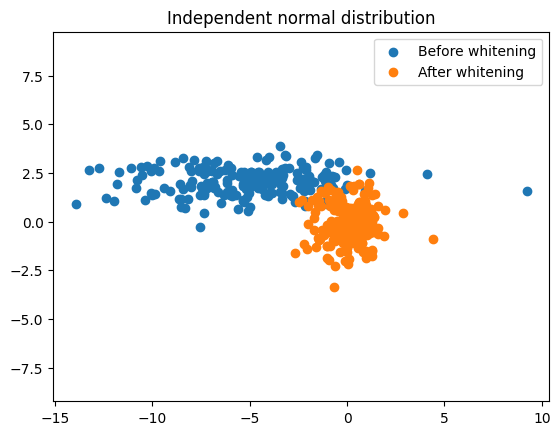

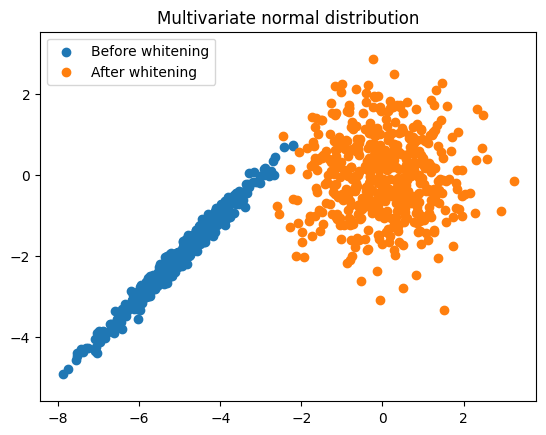

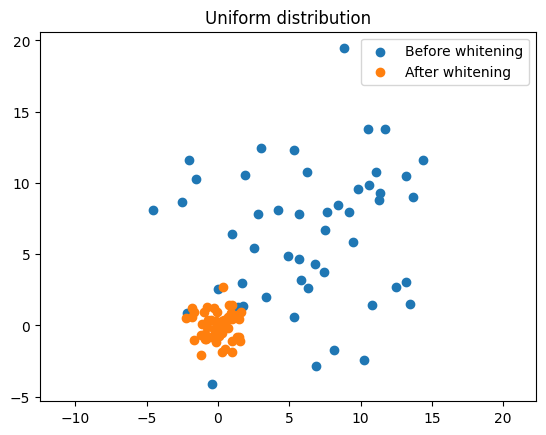

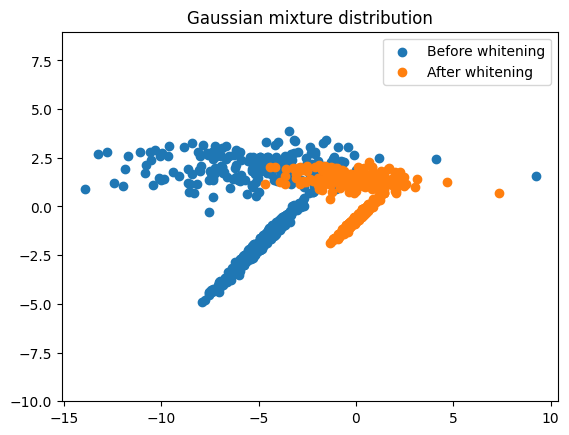

In [13]:
X_diag_normal = np.random.multivariate_normal([-5, 2.0], [[10, 0], [0, 0.5]], size=200)
X_multivariate_normal = np.random.multivariate_normal([-5, -2], [[1, 0.99], [0.99, 1]], size=500)
X_uniform = np.random.normal(6, 5, size=(50, 2))
X_gmm = np.concatenate((X_multivariate_normal, X_diag_normal), axis=0)

utils.scatter_with_whiten(X_diag_normal, whiten, name="Independent normal distribution")
utils.scatter_with_whiten(X_multivariate_normal, whiten, name="Multivariate normal distribution")
utils.scatter_with_whiten(X_uniform, whiten, name="Uniform distribution")
utils.scatter_with_whiten(X_gmm, whiten, name="Gaussian mixture distribution")

## Standaryzacja a whitening
W pierwszym notebooku implementowaliśmy następującą funkcję, która wykonuje zadanie podobne do whiteningu:

$$ f(x_{ij}) = \frac{x_{ij} - \mu_j}{\sigma_j} $$

Tę funkcję nazwijmy **standaryzacją**. Czym zatem różni się standaryzacja od whiteningu? Czy nie wystarczy znormalizować kolumn i zamiast tego musimy wykonywać znacznie bardziej kosztowną operację liczenia i odwracania macierzy kowariancji?

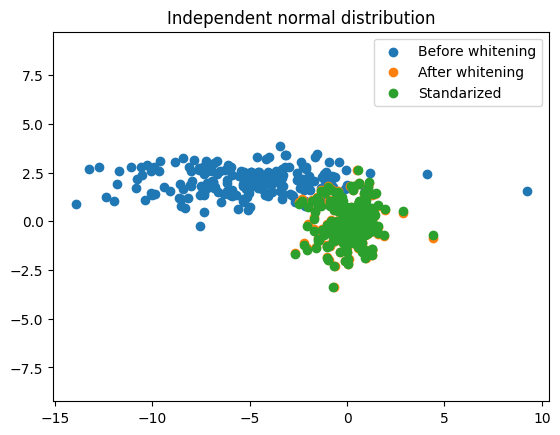

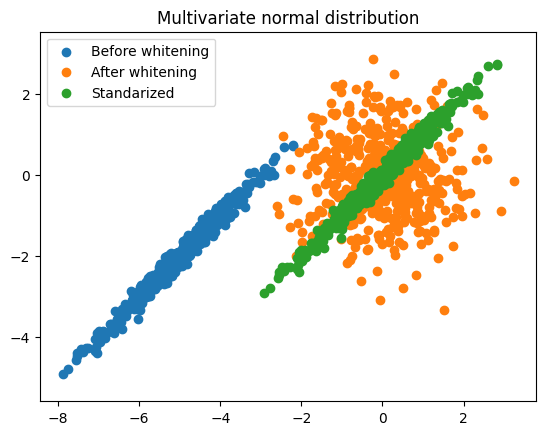

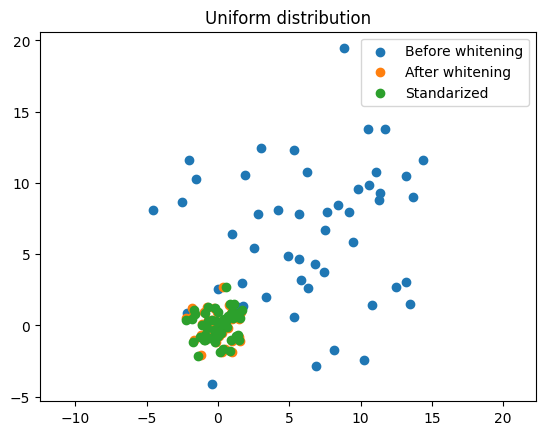

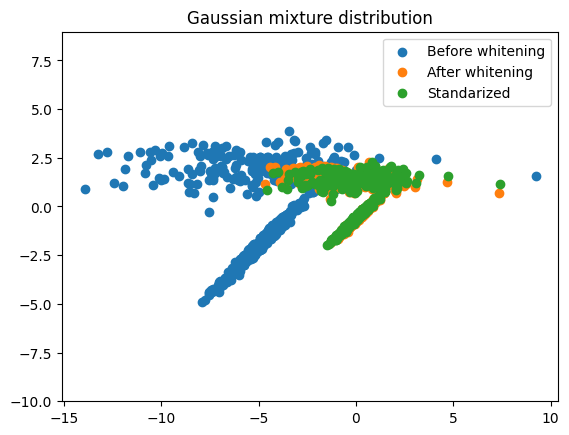

In [14]:
utils.scatter_with_whiten(
    X_diag_normal, whiten, name="Independent normal distribution", standarize=True
)
utils.scatter_with_whiten(
    X_multivariate_normal, whiten, name="Multivariate normal distribution", standarize=True
)
utils.scatter_with_whiten(X_uniform, whiten, name="Uniform distribution", standarize=True)
utils.scatter_with_whiten(X_gmm, whiten, name="Gaussian mixture distribution", standarize=True)

## Zadanie 3. (2 pkt.)
Należy:
1. Wysamplować $10000$ przykładów z rozkładu normalnego $\mathcal{N}(\mu, \sigma)$. **Należy wybrać niestandardowe parametry**, tzn. $\mu \neq 0$ oraz $\sigma \neq 1$.
2. Następnie należy policzyć, jaki procent wylosowanych przykładów, znajduje się od środka w odległości większej niż: 
    * $1\sigma$ (tzn. $|x - \mu| > 1\sigma$)
    * $2\sigma$ (tzn. $|x - \mu| > 2\sigma$)
    * $3\sigma$ (tzn. $|x - \mu| > 3\sigma$)
    
3. Wypisać wszystkie przykłady, które wpadają do ostatniej kategorii (tzn. są oddalone o co najmniej $3\sigma$ od średniej).

32.38%
4.73%
0.29%
[-1.67418184 11.3098905  -1.04180448 -1.02066289 -1.02760028 11.19136899
 -1.38153478 -1.75874454 11.2719865  -1.02039124 11.56605894 12.33424835
 -1.03487685 -1.25079873 -2.00965267 11.59995126 11.51467787 -2.96153212
 11.80627242 11.37127946 11.61751813 -1.64016751 -2.15426804 11.27161812
 -1.09579957 11.65513561 11.53465715 -1.8536958  11.36649702]


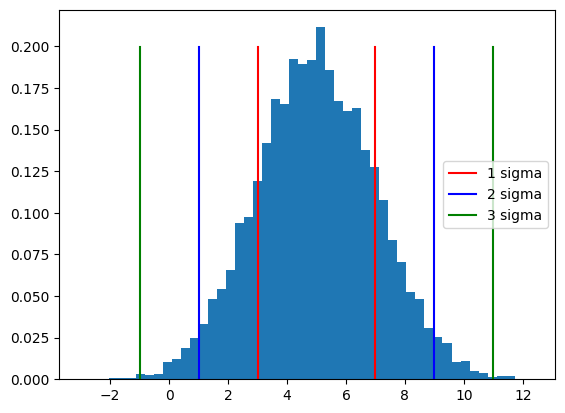

In [15]:
# Podpunkt 1: Wysamplować 10000 przykładów z rozkładu normalnego
loc = 5  # średnia wybranego rozkładu normalnego
scale = 2  # odchylenie standardowe wybranego rozkładu normalnego
X = np.random.normal(loc, scale, 10000)

# Podpunkt 2: Wyliczyć i wypisać procent 
sigma_1 = np.sum(np.abs(X - loc) > scale) / len(X) * 100
sigma_2 = np.sum(np.abs(X - loc) > 2 * scale) / len(X) * 100
sigma_3 = np.sum(np.abs(X - loc) > 3 * scale) / len(X) * 100

print(f"{sigma_1:.2f}%")
print(f"{sigma_2:.2f}%")
print(f"{sigma_3:.2f}%")

# Podpunkt 3: Wypisać elementy, które są oddalone od średniej o 3 sigma.
X_3_sigma = X[np.abs(X - loc) > 3 * scale]
print(f"{X_3_sigma}")


# Trochę wizualizacji
utils.visualize_normal_dist(X, loc, scale)